<a href="https://colab.research.google.com/github/AbrahamOtero/MLiB/blob/main/6_MetaModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combination of models
We import the libraries that we are going to need:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Voting

We will start by implementing a voting strategy using **VotingClassifier**. We will use three models (although you can add more models if you want): a decision tree, K nearest neighbors, and Naive Bayes. We will apply it to the diabetes dataset, and perform a 10-fold evaluation.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/AbrahamOtero/MLiB/main/datasets/diabetes.csv'

diabetes = pd.read_csv(url)

# The featrures
X = diabetes.iloc[:, :-1]
# The class
y = diabetes.iloc[:,-1]

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# We will reserve a set of test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# We build the voting-based classifier
voting_clf = VotingClassifier(
    # Map of classifiers that "vote". We indicate their name (any string of characters) and the classifier
    estimators=[
        ('dt', DecisionTreeClassifier()),
        ('knn', KNeighborsClassifier()),
        ('gnb', GaussianNB())
    ]
)
voting_clf.fit(X_train, y_train)

scores = cross_val_score(voting_clf, X_train, y_train, cv=10, scoring="accuracy")
# Calculate and display the average accuracy value and standard deviation for the scores of each fold
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Mean accuracy: 0.7543478260869565
Standard deviation: 0.05149008383620441


Let's see how each of the three classifiers performs, as well as the performance of the voting model composed of the three classifiers. We will use the 10% of data that we saved for testing:

In [3]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

print("Voting: ", voting_clf.score(X_test, y_test))

dt = 0.7175324675324676
knn = 0.7142857142857143
gnb = 0.7597402597402597
Voting:  0.775974025974026


We see that the performance of the model composed of the three classifiers is slightly higher than the performance of each of them. In practice this does not always have to be the case (especially if the errors of the different classifiers are correlated, or if one classifier is much better than the others). But we can often improve the performance of each individual model using voting.



## Bagging

An obvious approach to the "vote" strategy is to use multiple versions of the same classifier over altered versions (using sampling) of the data set. For example, using multiple decision trees trained over different versions of a datset. We can do this easily by using **BaggingClassifier**:

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# To build each model we will use a number of samples equal to half of those available.
# This is a hyperparameter you may change
n_smples = round(X_train.shape[1]/2)

#We created a Bagging classifier composed of 100 decision trees
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=n_smples)
socres = cross_val_score(bag_clf, X_train, y_train, cv=10, scoring="accuracy")

# Calculate and display the average accuracy value and standard deviation for the scores of each fold
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Mean accuracy: 0.7543478260869565
Standard deviation: 0.05149008383620441


### Random Forests

A Random Forest is similar to a bag of decision trees. The main difference is that the decision trees are going to be built with different parameters (for example, maximum number of depth levels, a minimum number of instances in each different leaf). When using Bagging all the classifiers have been built with the same parameters, but training over different dataset created using sampling.


In [5]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100)

scores = cross_val_score(rnd_clf, X_train, y_train, cv=10, scoring="accuracy")

# Calculate and display the average accuracy value and standard deviation for the scores of each fold
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Mean accuracy: 0.7565217391304349
Standard deviation: 0.04742918310711181


An interesting property of the Scikit Learn random tree classifier is that it can evaluate how important each attribute is based on how many times it was chosen to be used by the decision trees. To do this we will have to re-fit the classifier on the data (as we used cross_val_score in the previous code):

In [6]:
# Fit the classifier
rnd_clf.fit(X_train, y_train)

# Feature relevance
print ('Relevance Feature')
for score, name in zip(rnd_clf.feature_importances_, diabetes.columns):
    print(round(score, 2), '\t' , name)

Relevance Feature
0.08 	 Pregnancies
0.25 	 Glucose
0.09 	 BloodPressure
0.07 	 SkinThickness
0.07 	 Insulin
0.16 	 BMI
0.12 	 DiabetesPedigreeFunction
0.15 	 Age


## Boosting

To use Boosting we can use **AdaBoostClassifier**. In each iteration, this classifier places more emphasis on the errors made by the previous classifiers.

In [7]:
from sklearn.ensemble import AdaBoostClassifier

# algorithm= 'SAMME'avoids warning due to use of a deprecated strategy
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, algorithm= 'SAMME')

scores = cross_val_score(ada_clf, X_train, y_train, cv=10, scoring="accuracy")

# Calculate and display the average accuracy value and standard deviation for the scores of each fold
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())



Mean accuracy: 0.717391304347826
Standard deviation: 0.04861017342390848


## Stacking

Finall we will use Stacking using the classifier **StackingClassifier**. It will have 3 level 0 models (decision trees, nearest neighbors and Bayesian classifier) ​​and the level 1 classifier will be a neural network.

In [8]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

stacking_clf = StackingClassifier(
     # Map of level 0 models
    estimators=[
        ('dt', DecisionTreeClassifier()),
        ('knn', KNeighborsClassifier()),
        ('gnb', GaussianNB())
    ],
     # Level 1 model than takes as inputs the predictions of the previous models
    final_estimator=MLPClassifier(hidden_layer_sizes=(10,10))
)

scores = cross_val_score(stacking_clf, X_train, y_train, cv=10, scoring="accuracy")

# Calculate and display the average accuracy value and standard deviation for the scores of each fold
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Mean accuracy: 0.7413043478260869
Standard deviation: 0.053647663822839434


# Evaluation of classifiers based on cost

Unfortunately Scikit learn does not have functionality directly to evaluate classifiers based on cost. We will rely on the following code (obtained from the following repository https://github.com/Treers/MetaCost). You will need to run this to create the cost based classifier. If you use it in your project, you will also need to load this class in the environment.

In [9]:
# Just run this code to loas the MetaCost classifier in the environment

import pandas as pd
import numpy as np
from sklearn.base import clone

class MetaCost(object):

    """A procedure for making error-based classifiers cost-sensitive

    >>> from sklearn.datasets import load_iris
    >>> from sklearn.linear_model import LogisticRegression
    >>> import pandas as pd
    >>> import numpy as np
    >>> S = pd.DataFrame(load_iris().data)
    >>> S['target'] = load_iris().target
    >>> LR = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    >>> C = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
    >>> model = MetaCost(S, LR, C).fit('target', 3)
    >>> model.predict_proba(load_iris().data[[2]])
    >>> model.score(S[[0, 1, 2, 3]].values, S['target'])

    .. note:: The form of the cost matrix C must be as follows:
    +---------------+----------+----------+----------+
    |  actual class |          |          |          |
    +               |          |          |          |
    |   +           | y(x)=j_1 | y(x)=j_2 | y(x)=j_3 |
    |       +       |          |          |          |
    |           +   |          |          |          |
    |predicted class|          |          |          |
    +---------------+----------+----------+----------+
    |   h(x)=j_1    |    0     |    a     |     b    |
    |   h(x)=j_2    |    c     |    0     |     d    |
    |   h(x)=j_3    |    e     |    f     |     0    |
    +---------------+----------+----------+----------+
    | C = np.array([[0, a, b],[c, 0 , d],[e, f, 0]]) |
    +------------------------------------------------+
    """
    def __init__(self, S, L, C, m=50, n=1, p=True, q=True):
        """
        :param S: The training set
        :param L: A classification learning algorithm
        :param C: A cost matrix
        :param q: Is True iff all resamples are to be used  for each examples
        :param m: The number of resamples to generate
        :param n: The number of examples in each resample
        :param p: Is True iff L produces class probabilities
        """
        if not isinstance(S, pd.DataFrame):
            raise ValueError('S must be a DataFrame object')
        new_index = list(range(len(S)))
        S.index = new_index
        self.S = S
        self.L = L
        self.C = C
        self.m = m
        self.n = len(S) * n
        self.p = p
        self.q = q

    def fit(self, flag, num_class):
        """
        :param flag: The name of classification labels
        :param num_class: The number of classes
        :return: Classifier
        """
        col = [col for col in self.S.columns if col != flag]
        S_ = {}
        M = []

        for i in range(self.m):
            # Let S_[i] be a resample of S with self.n examples
            S_[i] = self.S.sample(n=self.n, replace=True)

            X = S_[i][col].values
            y = S_[i][flag].values

            # Let M[i] = model produced by applying L to S_[i]
            model = clone(self.L)
            M.append(model.fit(X, y))

        label = []
        S_array = self.S[col].values
        for i in range(len(self.S)):
            if not self.q:
                k_th = [k for k, v in S_.items() if i not in v.index]
                M_ = list(np.array(M)[k_th])
            else:
                M_ = M

            if self.p:
                P_j = [model.predict_proba(S_array[[i]]) for model in M_]
            else:
                P_j = []
                vector = [0] * num_class
                for model in M_:
                    vector[model.predict(S_array[[i]])] = 1
                    P_j.append(vector)

            # Calculate P(j|x)
            P = np.array(np.mean(P_j, 0)).T

            # Relabel
            label.append(np.argmin(self.C.dot(P)))

        # Model produced by applying L to S with relabeled y
        X_train = self.S[col].values
        y_train = np.array(label)
        model_new = clone(self.L)
        model_new.fit(X_train, y_train)

        return model_new

We will start by training a decision tree without considering the cost using the diabees data set. We will show the accuracy and the confusion matrix:

Accuracy: 0.7305194805194806
Confusion Matrix:
[[152  54]
 [ 29  73]]


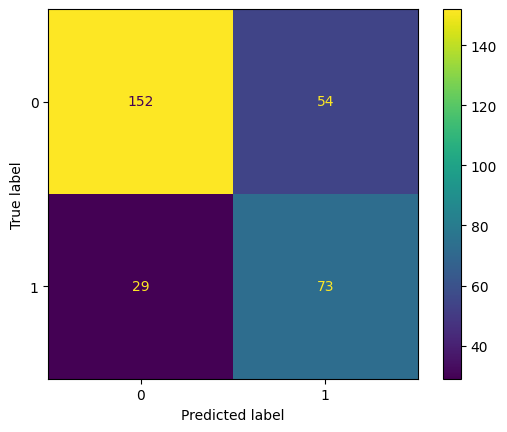

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Assuming X and y are already defined (from your previous code)
# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
confusion_mat_tree = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat_tree)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat_tree,
                              display_labels=dt_classifier.classes_)
disp.plot()
plt.show()

Note that the confusion matrix generated by SKlearn has the true classes in the rows, and the predicted classes in the columns. However, if you look at the **MetaCost documentation, it expects just the opposite**: true classes in the columns and predicted classes in the rows. We will need to take this into account when interpreting the results and calculating the costs.

Now we shall train MetaCost, but with a cost matrix where all errors have the same cost.

In [11]:
# Define the cost matrix
cost_matrix = np.array([[0, 1], [1, 0]])

# Combine X_train and y_train into a single DataFrame
# MetaCost needs all the data to be arranged in a DataFrame
train_df = pd.DataFrame(data=X_train)
train_df['Outcome'] = pd.array(y_train)

# Create a MetaCost object with a DecisionTreeClassifier
metacost_model = MetaCost(train_df, DecisionTreeClassifier(random_state=42), cost_matrix)

# Fit the model to the training data.
# We need to indicate the colum of the class ('Outcome') and the number of classes (2)
model = metacost_model.fit('Outcome', 2)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.7305194805194806
Confusion Matrix:
[[152  54]
 [ 29  73]]


Note how by using the same cost for all errors we have obtained exactly the same confusion matrix as in the previous case (the standard classifier).

Now we will carry out the training considering that classifying a diabetic patient as healthy has a cost 10 times higher than classifying a healthy patient as diabetic.

(Note: The MetaCost classifier does not provide an interface that permits an easy control of its random state. If you run code that uses this classifier, you may get slightly different results than the text indicates for this reason.)

In [12]:
# Define the cost matrix
cost_matrix = np.array([[0, 10], [1, 0]])

# Create a MetaCost object with a DecisionTreeClassifier
metacost_model = MetaCost(train_df, DecisionTreeClassifier(random_state=42), cost_matrix)

# Fit the model to the training data.
# We need to indicate the colum of the class ('Outcome') and the number of classes (2)
model = metacost_model.fit('Outcome', 2)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# Calculate the cost of the classifier
# We have to transpose the cost matrix because the confusion matrix arranges
# the rows and columns in the opposite way
cost = np.sum(confusion_mat * np.transpose(cost_matrix))

# Print the cost
print("Cost:", cost)
# Print the cost per instance
print("Cost per instance:", cost/len(y_test))

Accuracy: 0.6201298701298701
Confusion Matrix:
[[100 106]
 [ 11  91]]
Cost: 216
Cost per instance: 0.7012987012987013


The classifier's performance has dropped from about 73% to 67%. Its cost is 216 (0.70 per instance). What was the cost of the classifier that had an accuracy of 73%?

In [13]:
print(confusion_mat_tree)

# Calculate the cost of the classifier
cost = np.sum(confusion_mat_tree * np.transpose(cost_matrix))

# Print the cost
print("Cost:", cost)
# Print the cost per instance
print("Cost per instance:", cost/len(y_test))

[[152  54]
 [ 29  73]]
Cost: 344
Cost per instance: 1.1168831168831168


The cost of the classifier that had an accuracy of 73% is 344  (1.12 per instance), compared to the cost of 209. The classifier trained with MetaCost has lower accuracy, but lower cost. The classifier trained in the normal way has higher accuracy, but also higher cost. It makes fewer errors, but the type of errors it makes are the ones we want to avoid (they have higher cost).

Next, we will perform a cost-based training and evaluation using a 10-fold validation. MetaCost is not a SKlearn Predictor (it does not implement all the methods it should) so we will have to generate the folds manually.

In [14]:
from sklearn.model_selection import StratifiedKFold

# The featrures
X = diabetes.iloc[:, :-1]
# The class
y = diabetes.iloc[:,-1]

# Define the number of folds
n_splits = 10

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the  classifier
classifier = DecisionTreeClassifier(random_state=42)

# Define the cost matrix
cost_matrix = np.array([[0, 10], [1, 0]])

# Create an empty list to store the accuracy and cost scores for each fold
accuracy_scores = []
cost_scores = []

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
  # Split the data into training and validation sets for this fold
  X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]

  # Create a DataFrame for MetaCost
  train_df_fold = pd.DataFrame(data=X_train_fold)
  train_df_fold['Outcome'] = pd.array(y_train_fold)

  # Create and fit the MetaCost model for this fold
  metacost_model = MetaCost(train_df_fold, classifier, cost_matrix)
  model = metacost_model.fit('Outcome', 2)

  # Make predictions on the validation set for this fold
  y_pred_fold = model.predict(X_val_fold)

  # Calculate the accuracy for this fold
  accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
  accuracy_scores.append(accuracy_fold)

  # Calculate the cost for this fold
  confusion_mat = confusion_matrix(y_val_fold, y_pred_fold)
  cost = np.sum(confusion_mat * np.transpose(cost_matrix))
  cost_scores.append(cost)

#End of the cross fold validation loop

# Calculate and display the average accuracy and cost across all folds
print("Mean accuracy:", np.mean(accuracy_scores))
print("Standard deviation:", np.std(accuracy_scores))
print("Mean cost:", np.mean(cost_scores))
print("Standard deviation:", np.std(cost_scores))
divisor = len (y_val_fold)
cost_scores_per_instance = [x / divisor for x in cost_scores]
print("Mean cost:", np.mean(cost_scores_per_instance))
print("Standard deviation:", np.std(cost_scores_per_instance))

Mean accuracy: 0.6573137388926863
Standard deviation: 0.06315953140772021
Mean cost: 63.2
Standard deviation: 23.51510153071851
Mean cost: 0.8315789473684211
Standard deviation: 0.30940923066734877


Note that when comparing these results to the previous ones the total cost is not comparable, as the size of the data sets when using 10-fold validation is quite different. You should make the comparison at the cost per instance level. The cost is 0.83 per instance.

Let's compare these results to performing a 10-fold validation directly on the classifier, without using cost-based training (although we will also calculate the cost metric for this classifier, which has not taken cost into account during its training):

In [15]:
# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the cost matrix; it will only be used to evalutate; not to train
cost_matrix = np.array([[0, 10], [1, 0]])

# Create an empty list to store the accuracy and cost scores for each fold
accuracy_scores = []
cost_scores = []

# Iterate through the folds
for train_index, test_index in skf.split(X, y):
  # Split the data into training and validation sets for this fold
  X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]

  # Create and fit the model for this fold
  model = DecisionTreeClassifier(random_state=42)
  model.fit(X_train_fold, y_train_fold)

  # Make predictions on the validation set for this fold
  y_pred_fold = model.predict(X_val_fold)

  # Calculate the accuracy for this fold
  accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
  accuracy_scores.append(accuracy_fold)

  # Calculate the cost for this fold
  confusion_mat = confusion_matrix(y_val_fold, y_pred_fold)
  cost = np.sum(confusion_mat * np.transpose(cost_matrix))
  cost_scores.append(cost)

#End of the cross fold validation loop

# Calculate and display the average accuracy and cost across all folds
print("Mean accuracy:", np.mean(accuracy_scores))
print("Standard deviation:", np.std(accuracy_scores))
print("Mean cost:", np.mean(cost_scores))
print("Standard deviation:", np.std(cost_scores))
divisor = len (y_val_fold)
cost_scores_per_instance = [x / divisor for x in cost_scores]
print("Mean cost:", np.mean(cost_scores_per_instance))
print("Standard deviation:", np.std(cost_scores_per_instance))

Mean accuracy: 0.702939166097061
Standard deviation: 0.060908555498988284
Mean cost: 125.4
Standard deviation: 28.281442678901655
Mean cost: 1.65
Standard deviation: 0.37212424577502173


The average cost per instance is now 1.65+-0.37, compared to 0.83+-0.31 when we performed a cost-based evaluation. However, the accuracy was 0.66 +- 0.06, while in cost-based training the accuracy was 0.62 +-0.06. As always, we have had to sacrifice some accuracy to decrease the cost.

